# Preperation

### Imports

In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb

In [2]:
sys.path.append(os.path.abspath('../../src'))

from helper_functions.path_resolver import DynamicPathResolver
from helper_functions import visualization as visual

### Paths

In [ ]:
resolver = DynamicPathResolver(marker="README.md")
structure = resolver.structure

raw_data_path = structure.data.raw.data_mail.raw_combined_csv
preprocessed_data_path = structure.data.preprocessed.data_for_meta.meta_csv

Project Root: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection


In [40]:
models_folder = resolver.get_folder_path_from_namespace(structure.models.meta)
os.makedirs(models_folder, exist_ok=True)

output_dir = os.path.join(models_folder, "results")
os.makedirs(output_dir, exist_ok=True)

### Load and prepare data

In [18]:
meta_df = pd.read_csv(preprocessed_data_path)

In [19]:
df = pd.get_dummies(meta_df, columns=['language'], drop_first=True)

X = df.drop(columns=['labels'])
y = df['labels']

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [21]:
print("Class distribution in TRAIN:")
print(y_train.value_counts())

print("\nClass distribution in VAL:")
print(y_val.value_counts())

print("\nClass distribution in TEST:")
print(y_test.value_counts())

Class distribution in TRAIN:
labels
0    3859
1     598
Name: count, dtype: int64

Class distribution in VAL:
labels
0    483
1     74
Name: count, dtype: int64

Class distribution in TEST:
labels
0    483
1     75
Name: count, dtype: int64


# Training

### GDB

In [22]:
gdb_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=6)

In [23]:
gdb_start_time = time.time()
gdb_model.fit(X_train, y_train)
gdb_end_time = time.time()

print(f"Training time: {gdb_end_time - gdb_start_time:.4f} seconds")

Training time: 3.3106 seconds


In [24]:
gdb_model_path = os.path.join(models_folder, "gdb_model.pkl")
import joblib
joblib.dump(gdb_model, gdb_model_path)

['c:\\Users\\ilian\\Documents\\Projects\\git_projects\\university\\phishing_detection\\models\\meta\\gdb_model.pkl']

### Random Forest

In [25]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)

rf_start_time = time.time()
rf_model.fit(X_train, y_train)
rf_end_time = time.time()

print(f"Training time: {rf_end_time - rf_start_time:.4f} seconds")


Training time: 0.3870 seconds


In [26]:
rf_model_path = os.path.join(models_folder, "rf_model.pkl")
joblib.dump(rf_model, rf_model_path)

['c:\\Users\\ilian\\Documents\\Projects\\git_projects\\university\\phishing_detection\\models\\meta\\rf_model.pkl']

### XGBoost

In [27]:
xgboost_model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42)

xgboost_start_time = time.time()
xgboost_model.fit(X_train, y_train)
xgboost_end_time = time.time()

print(f"Training time: {xgboost_end_time - xgboost_start_time:.4f} seconds")


Training time: 0.4406 seconds


In [28]:
xgboost_model_path = os.path.join(models_folder, "xgboost_model.pkl")
joblib.dump(xgboost_model, xgboost_model_path)

['c:\\Users\\ilian\\Documents\\Projects\\git_projects\\university\\phishing_detection\\models\\meta\\xgboost_model.pkl']

### SVM

In [29]:
svm_model = SVC(kernel='linear', C=1, random_state=42)

svm_start_time = time.time()
svm_model.fit(X_train, y_train)
svm_end_time = time.time()

print(f"Training time: {svm_end_time - svm_start_time:.4f} seconds")

Training time: 12.8309 seconds


In [30]:
svm_model_path = os.path.join(models_folder, "svm_model.pkl")
joblib.dump(svm_model, svm_model_path)

['c:\\Users\\ilian\\Documents\\Projects\\git_projects\\university\\phishing_detection\\models\\meta\\svm_model.pkl']

# Evaluation

### Load models

In [31]:
# Load Gradient Boosting model
gdb_model_path = os.path.join(models_folder, "gdb_model.pkl")
gdb_model = joblib.load(gdb_model_path)

# Load Random Forest model
rf_model_path = os.path.join(models_folder, "rf_model.pkl")
rf_model = joblib.load(rf_model_path)

# Load XGBoost model
xgboost_model_path = os.path.join(models_folder, "xgboost_model.pkl")
xgboost_model = joblib.load(xgboost_model_path)

# Load SVM model
svm_model_path = os.path.join(models_folder, "svm_model.pkl")
svm_model = joblib.load(svm_model_path)

### Predict eval and test

In [32]:
model = rf_model   # svm_model xgboost_model rf_model gdb_model

In [33]:
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

### Classification report

In [39]:
print("Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       483
           1       0.94      0.86      0.90        74

    accuracy                           0.97       557
   macro avg       0.96      0.93      0.94       557
weighted avg       0.97      0.97      0.97       557

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       483
           1       0.97      0.85      0.91        75

    accuracy                           0.98       558
   macro avg       0.97      0.92      0.95       558
weighted avg       0.98      0.98      0.98       558



### Confusion matrix

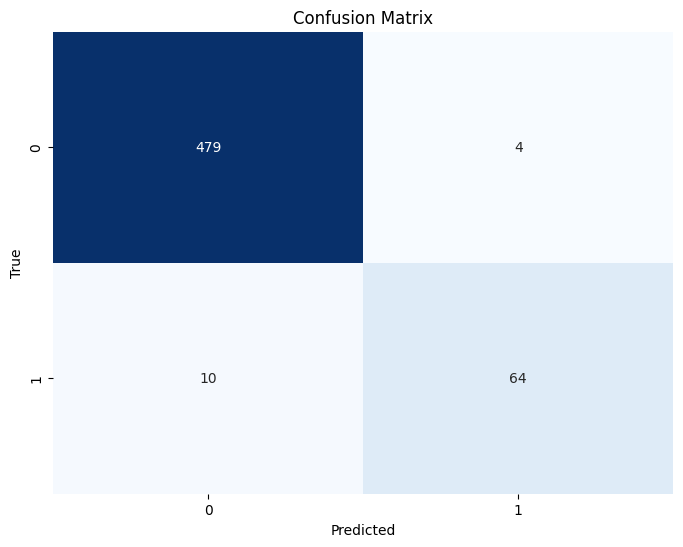

In [41]:
cm_val = confusion_matrix(y_val, y_val_pred)
visual.plot_confusion_matrix(cm_val, output_dir, "val")

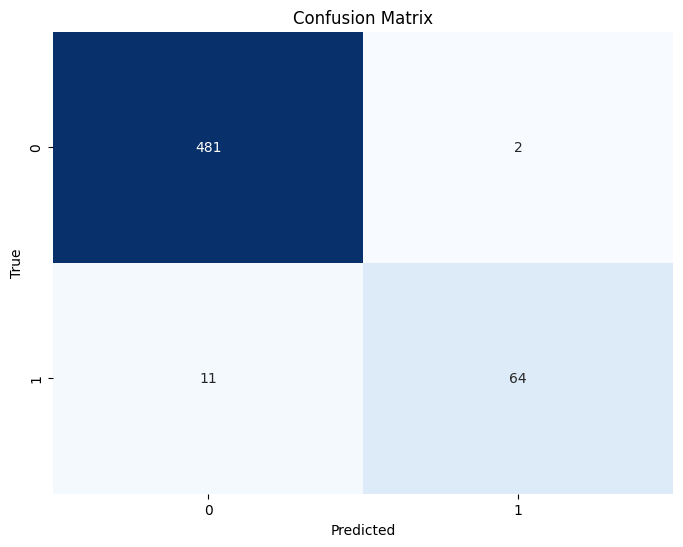

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)
visual.plot_confusion_matrix(cm_test, output_dir, "test")

### Feature Importance Plot

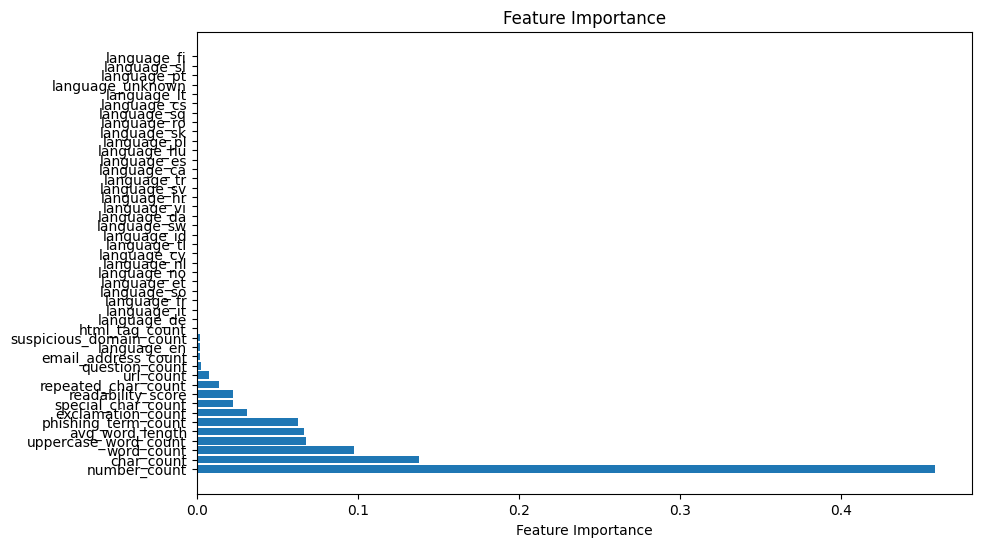

In [36]:
feature_importances = model.feature_importances_
features = X.columns

sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()